In [1]:
import os
import sys
import itertools

sys.path.append(".")  # Add the parent directory of LLM_Evaluations to the Python path
from statistics_plots_analysis_utils import *

def process_model_group(model_name, model_df, expert_group_df, questions_to_sum=None, group_num=None):
    model_group_df = model_df[model_df['Video ID'].isin(expert_group_df['Video ID'])].reset_index(drop=True)

    # Binarize scores for Group A
    if questions_to_sum and group_num == 1:
        for column in questions_to_sum:
            model_group_df[column] = model_group_df[column].apply(binarize_value)

    # Find total score, either selected columns for Group A, or all columns for Group B
    if questions_to_sum:
        model_group_df = sum_columns(model_group_df, questions_to_sum)

    # Merge expert and models scores, either total for gourp 1 and 2, or all scores for Group C
    columns_to_merge = ['Video ID'] + (['Model Total'] if questions_to_sum else MODEL_15_SCORE_COLUMNS)
    expert_group_df = merge_dataframes(expert_group_df, model_group_df, columns_to_merge)

    # Rename model score column to be as the model name; i.e. GPT-4 / Claude-3 / etc.
    if questions_to_sum:
        expert_group_df.rename(columns={'Model Total': model_name}, inplace=True)
    else:
        new_column_names = {f"Q{i}": f"{model_name} Q{i}" for i in range(1, 16)}
        expert_group_df.rename(columns=new_column_names, inplace=True)

    return expert_group_df

def plot_models_agreement_heatmap(group_df: pd.DataFrame, model_names, categories, 
                                  agreement_coef, topic_name, figsize=(13, 6)):
    models_agreement_df = pd.DataFrame(index=model_names[:-1], columns=model_names[1:], dtype=float)

    # Fill only the upper triangular part of the DataFrame with the 'agreement_coef' values
    for model1, model2 in itertools.combinations(model_names, 2):
        stat = calculate_statistics(group_df, model1, model2, categories)
        models_agreement_df.at[model1, model2] = stat.get(agreement_coef)

    if topic_name:
        topic_name += ': '    
    create_plot('heatmap', data=models_agreement_df,
                figsize=figsize,
                title=f'{topic_name}Agreement between Models ({agreement_coef}) Heatmap',
                xticks_rotation=90)
    
    return models_agreement_df

def model_agreements_gt_per(models_agreement_df, percent, topic_name='', figsize=(10, 4)):
    # Stack the DataFrame to convert it into a Series
    stacked_df = models_agreement_df[models_agreement_df > percent].stack()

    # Sort the Series (which contains the values of the DataFrame) in descending order
    sorted_stacked_df = stacked_df.sort_values(ascending=False)

    # Convert the sorted Series back to a DataFrame
    sorted_models_agreement_df = sorted_stacked_df.unstack()

    if topic_name:
        topic_name += ': '    
    create_plot('heatmap', data=sorted_models_agreement_df,
                figsize=figsize,
                title=f'{topic_name}Models Agreement (> {percent}) Heatmap',
                xticks_rotation=90)

def plot_questionwise_agreement_heatmap(stat_group_df: pd.DataFrame, agreement_coef, 
                                        topic_name, figsize=None):
    question_avg = stat_group_df.mean(axis=1).values.reshape(-1, 1).round(2)
    model_avg = stat_group_df.mean(axis=0).values.reshape(1, -1).round(2)

    if figsize is None:
        (m, n) = stat_group_df.shape
    else:
        (m, n) = figsize

    asp = 0.5 * m / float(n)
    figw = n
    figh = figw * asp
    gridspec_kw = {'height_ratios': [m, 1], 'width_ratios': [n, 1]}
    fig, axes = plt.subplots(2, 2, figsize=(figw, figh), gridspec_kw=gridspec_kw)

    plt.subplots_adjust(top=0.90, wspace=0.05, hspace=0.1)

    hm_kwargs = dict(vmin=0, vmax=1, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5, linecolor='black')

    # Plot stat_groupC_df heatmap
    sns.heatmap(stat_group_df, ax=axes[0, 0], xticklabels=False, cbar=False, **hm_kwargs)

    # Plot q_avg heatmap
    sns.heatmap(question_avg, ax=axes[0, 1], yticklabels=False, **hm_kwargs)
    axes[0, 1].set_xticklabels(['Question Avg'])

    # Plot model_avg heatmap
    sns.heatmap(model_avg, ax=axes[1, 0], cbar=False, **hm_kwargs)
    axes[1, 0].set_xticklabels(stat_group_df.columns, rotation=90)
    axes[1, 0].set_yticklabels(['Model Avg'])

    # Hide the empty subplot
    axes[1, 1].axis('off')

    # plt.tight_layout()
    fig.suptitle(f'{topic_name}: Expert-Model Question-Wise Agreement Heatmap ({agreement_coef})', fontsize=16)

    plt.show()

## Evaluate LLM Evaluation

Zero-Shot Prompting: 7 topics

In [2]:
model_names_and_files = {
    "BioMistral": "BioMistral-response.csv",
    "Claude-3 Sonnet": "claude-3-sonnet-20240229-response.csv",
    "Falcon 40B": "falcon-40b-instruct-response.csv",
    "Gemini-1.0 Pro": "gemini-1.0-pro-latest-response.csv",
    "GPT-4 Turbo": "gpt-4-turbo-response.csv",
    # "GPT-4o": "gpt-4o-last_3_topics-COT_prompting-response.csv",
    "KTO Mistral": "KTO_Mistral_PairRM-response.csv",
    "Llama-3 70B": "Llama-3-70B-Instruct-response.csv",
    "Llama-3 8B": "Llama-3-8B-Instruct-response user-only-prompt.csv",
    "Meerkat": "meerkat-response.csv",
    "Mistral 7B": "Mistral-7B-Instruct-response.csv",
    "Mixtral 8x22B": "Mixtral-8x22B-Instruct-response.csv",
    "Mixtral 8x7B": "Mixtral-8x7B-Instruct-response.csv",
    "MultiVerse 70B": "MultiVerse_70B-response.csv",
    "Orca-2": "Orca-2-do_sample=false-response.csv",
    "Phi-3 mini": "Phi-3-mini-4k-instruct-response.csv",
    "Qwen-1.5 72B": "Qwen1_5-72B-response.csv",
    "Rhea": "Rhea-response.csv",
    "Vicuna 33B": "vicuna-33b-response.csv",
    "Yi 34B": "Yi-34B-response.csv",
}

Zero-shot Prompting: ISA topic

In [3]:
model_names_and_files = {
    "Claude-3 Sonnet": "claude-3-sonnet-20240229-diabetes-ZS_prompting-response.csv",
    "Gemini-1.0 Pro": "gemini-1.0-pro-latest-diabetes-ZS_prompting-response.csv",
    "Gemini-1.5 Pro": "gemini-1.5-pro-latest-diabetes-ZS_prompting-response.csv",
    "GPT-4o": "gpt-4o-diabetes-ZS_prompting-response.csv",
}

Chain-of-Thought Prompting: last 3 topics

In [2]:
model_names_and_files = {
    "Claude-3 Sonnet": "claude-3-sonnet-20240229-last_3_topics-COT_prompting-response.csv",
    "Gemini-1.0 Pro": "gemini-1.0-pro-last_3_topics-COT_prompting-response.csv",
    "GPT-4o": "gpt-4o-last_3_topics-COT_prompting-response.csv",
}

Zero-shot: binary questions: first 2 topics

In [2]:
model_names_and_files = {
    # "Claude-3 Sonnet": "claude-3-sonnet-20240229-diabetes-zero_shot_prompting-response.csv",
    "Gemini-1.0 Pro": "gemini-1.0-pro-first_2_topics-ZS_prompting-binary_questions-response.csv",
    "Gemini-1.5 Pro": "gemini-1.5-pro-latest-first_2_topics-ZS_prompting-binary_questions-response.csv",
    "GPT-4o": "gpt-4o-first_2_topics-ZS-binary_questions-response.csv",
}

### Prepare Three Groups

In [3]:
# experts_file = "../../../Videos_and_DISCERN_data/all_experts_scores.csv"
experts_file = "../../../Videos_and_DISCERN_data/filtered_experts_scores.csv"
# experts_file = "../../../Videos_and_DISCERN_data/diabetes_experts_scores.csv"
experts_df = pd.read_csv(experts_file)

print(experts_df.shape)
print(experts_df['Topic'].value_counts())
experts_df.head(2)

(276, 35)
Topic
Nocturnal Enuresis     57
Cluster Headache       54
Trigger Finger         44
Spina Bifida           36
Pudendal Nerve         35
Delayed Ejaculation    25
Flat Feet              25
Name: count, dtype: int64


,Video ID,Topic,Expert1,Expert2,Experts_Avg,Expert1 Q1,Expert1 Q2,Expert1 Q3,Expert1 Q4,Expert1 Q5,...,Expert2 Q6,Expert2 Q7,Expert2 Q8,Expert2 Q9,Expert2 Q10,Expert2 Q11,Expert2 Q12,Expert2 Q13,Expert2 Q14,Expert2 Q15
0,OWtlKJbg_Pc,Nocturnal Enuresis,2,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,95T3ABnnhOs,Nocturnal Enuresis,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Split Expert DataFrame on Topic Groups

In [4]:
groupA_df = filter_df_by_topics(experts_df, TOPICS, ['NE', 'DE'], 
                                return_cols=['Video ID', 'Topic'] + EXPERT_TOTAL_COLUMNS)

# groupB_df = filter_df_by_topics(experts_df, TOPICS, ['ISA'],
groupB_df = filter_df_by_topics(experts_df, TOPICS, ['SB', 'FF', 'CH', 'TF', 'PN', 'ISA'], 
                                return_cols=['Video ID', 'Topic'] + EXPERT_TOTAL_COLUMNS)

# groupC_df = filter_df_by_topics(experts_df, TOPICS, ['ISA'], 
groupC_df = filter_df_by_topics(experts_df, TOPICS, ['CH', 'TF', 'PN', 'ISA'], 
                                return_cols=experts_df.columns)
groupC_df = calculate_experts_avg_of_questions(groupC_df, EXPERT1_COLUMNS, EXPERT2_COLUMNS)
# groupC_df = groupC_df[['Video ID', 'Topic', *[f"Experts_Avg Q{i}" for i in range(1, 16)]]]

print("Group A shape:", groupA_df.shape)
print("Group B shape:", groupB_df.shape)
print("Group C shape:", groupC_df.shape)

Group A shape: (82, 5)
Group B shape: (194, 5)
Group C shape: (133, 50)


#### Load LLM Scores

In [5]:
models_dir = "../../../Results/LLMs_Responses"
# model_files = [f for f in os.listdir(models_dir) if f.endswith('.csv')]
model_names = list(model_names_and_files.keys())

for model_name, model_file in model_names_and_files.items():
    # model_name = model_file.split('-response')[0]
    model_path = os.path.join(models_dir, model_file)
    model_df = pd.read_csv(model_path, encoding="utf-8", usecols=['Video ID'] + MODEL_15_SCORE_COLUMNS[:])

    groupA_df = process_model_group(model_name, model_df, groupA_df, 
                                            questions_to_sum=['Q1', 'Q4', 'Q6', 'Q7', 'Q8'],
                                            # questions_to_sum=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'],
                                            group_num=1)
    
    groupB_df = process_model_group(model_name, model_df, groupB_df, 
                                            questions_to_sum=MODEL_15_SCORE_COLUMNS)
    
    groupC_df = process_model_group(model_name, model_df, groupC_df)
    
print("Group A shape:", groupA_df.shape)
groupA_df.head(2)

Group A shape: (82, 24)


,Video ID,Topic,Expert1,Expert2,Experts_Avg,BioMistral,Claude-3 Sonnet,Falcon 40B,Gemini-1.0 Pro,GPT-4 Turbo,...,Mistral 7B,Mixtral 8x22B,Mixtral 8x7B,MultiVerse 70B,Orca-2,Phi-3 mini,Qwen-1.5 72B,Rhea,Vicuna 33B,Yi 34B
0,OWtlKJbg_Pc,Nocturnal Enuresis,2,2.0,2.0,5,3,5,0,3,...,5,2,5,2,3,5,3,2,2,5
1,95T3ABnnhOs,Nocturnal Enuresis,1,1.0,1.0,4,2,5,1,3,...,3,2,4,2,5,4,3,2,4,5


In [6]:
print("Group B shape:", groupB_df.shape)
groupB_df.head(2)

Group B shape: (194, 24)


,Video ID,Topic,Expert1,Expert2,Experts_Avg,BioMistral,Claude-3 Sonnet,Falcon 40B,Gemini-1.0 Pro,GPT-4 Turbo,...,Mistral 7B,Mixtral 8x22B,Mixtral 8x7B,MultiVerse 70B,Orca-2,Phi-3 mini,Qwen-1.5 72B,Rhea,Vicuna 33B,Yi 34B
0,t6PP67AsJaI,Spina Bifida,26,25.0,25.5,71,48,60,26.0,39,...,59.0,45,43,30,48,69,51,36,63,67
1,TuLAGDTpR6Y,Spina Bifida,32,33.0,32.5,73,53,65,46.0,50,...,72.0,44,62,46,61,72,63,54,71,75


In [7]:
print("Group C shape:", groupC_df.shape)
groupC_df.head(2)

Group C shape: (133, 335)


,Video ID,Topic,Expert1,Expert2,Experts_Avg,Expert1 Q1,Expert1 Q2,Expert1 Q3,Expert1 Q4,Expert1 Q5,...,Yi 34B Q6,Yi 34B Q7,Yi 34B Q8,Yi 34B Q9,Yi 34B Q10,Yi 34B Q11,Yi 34B Q12,Yi 34B Q13,Yi 34B Q14,Yi 34B Q15
0,WHGCRT9xgu0,Cluster Headache,28,NaN,28.0,5.0,5.0,5.0,5.0,1.0,...,5,5,5,4,5,5,5,1,5,5
1,0Fe0m0IF6r8,Cluster Headache,30,NaN,30.0,5.0,5.0,5.0,5.0,1.0,...,2,1,4,2,4,2,5,1,4,2


In [27]:
# groupB_df.to_csv("groupB_df.csv", encoding='utf-8', index=False)
# groupC_df.to_csv("groupC_df.csv", encoding='utf-8', index=False)

### Group A Analysis
Group A: Scores out of 5. Experts individual scores are not provided

In [8]:
topic_name = 'Group A'
categories = list(range(0,6))
agreement_coef = "Brennan-Prediger Kappa"

In [9]:
if 'Expert1' in groupA_df.columns and 'Expert2' in groupA_df.columns:
    agreement_expert1_vs_expert2 = calculate_statistics(groupA_df, 'Expert1', 'Expert2', categories)
    print(f"Agreement between Expert 1 and Expert 2:")
    print(pd.DataFrame.from_dict(agreement_expert1_vs_expert2, orient='index', columns=['Value']))

Agreement between Expert 1 and Expert 2:
                           Value
Brennan-Prediger Kappa  0.987460
Weighted Kappa          0.922495
Spearman's Rho          0.892671
Kendall's Tau           0.892441
ICC3                    0.925996
Gwet's AC2              0.994840


c:\Users\ku500989\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


Descriptive Statistics

In [11]:
if 'Expert1' in groupA_df.columns and 'Expert2' in groupA_df.columns:
    groupA_df.drop(columns=['Expert1', 'Expert2'], inplace=True)
statA_df = groupA_df.describe().round(2).T
columns_to_convert_type = ['count', 'min', 'max']
statA_df[columns_to_convert_type] = statA_df[columns_to_convert_type].astype(int)
statA_df.rename_axis('Model', axis=1, inplace=True)
statA_df

Model,count,mean,std,min,25%,50%,75%,max
Experts_Avg,82,1.32,0.55,1,1.0,1.0,1.88,4
BioMistral,82,2.85,1.76,0,1.0,3.0,5.00,5
Claude-3 Sonnet,82,2.10,1.05,0,1.0,2.0,3.00,4
Falcon 40B,82,4.88,0.48,2,5.0,5.0,5.00,5
Gemini-1.0 Pro,82,0.35,0.60,0,0.0,0.0,1.00,2
GPT-4 Turbo,82,1.59,1.07,0,1.0,2.0,2.00,4
KTO Mistral,82,2.45,1.19,0,2.0,3.0,3.00,5
Llama-3 70B,82,2.34,0.80,0,2.0,2.0,3.00,4
Llama-3 8B,82,3.12,1.18,1,2.0,3.0,4.00,5
Meerkat,82,3.65,1.29,0,3.0,4.0,5.00,5


Box Plot

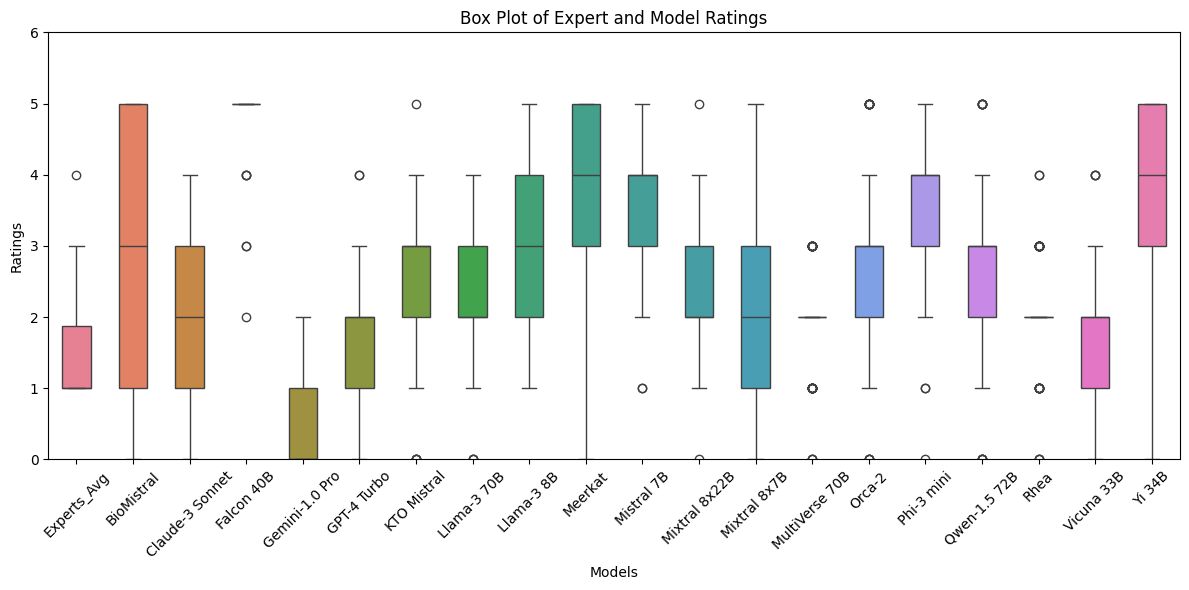

In [12]:
create_plot('boxplot', data=groupA_df,
            figsize=(12, 6), ylim=(0, 6),
            xlabel="Models", ylabel="Ratings",
            title="Box Plot of Expert and Model Ratings",
            xticks_rotation=45)

Expert-Models Inter-Rater Agreement

Model,Brennan-Prediger Kappa,Weighted Kappa,Spearman's Rho,Kendall's Tau,ICC3,Gwet's AC2
BioMistral,0.03,0.03,0.09,0.07,0.05,0.29
Claude-3 Sonnet,0.65,0.18,0.29,0.26,0.22,0.77
Falcon 40B,-1.15,0.01,0.18,0.18,0.15,-0.26
Gemini-1.0 Pro,0.66,-0.01,-0.02,-0.02,-0.04,0.80
GPT-4 Turbo,0.77,0.30,0.37,0.33,0.29,0.85
KTO Mistral,0.53,0.18,0.39,0.34,0.28,0.67
Llama-3 70B,0.64,0.17,0.40,0.37,0.31,0.76
Llama-3 8B,0.24,0.13,0.47,0.41,0.34,0.42
Meerkat,-0.20,0.05,0.25,0.22,0.20,0.04
Mistral 7B,0.05,0.08,0.45,0.40,0.30,0.24


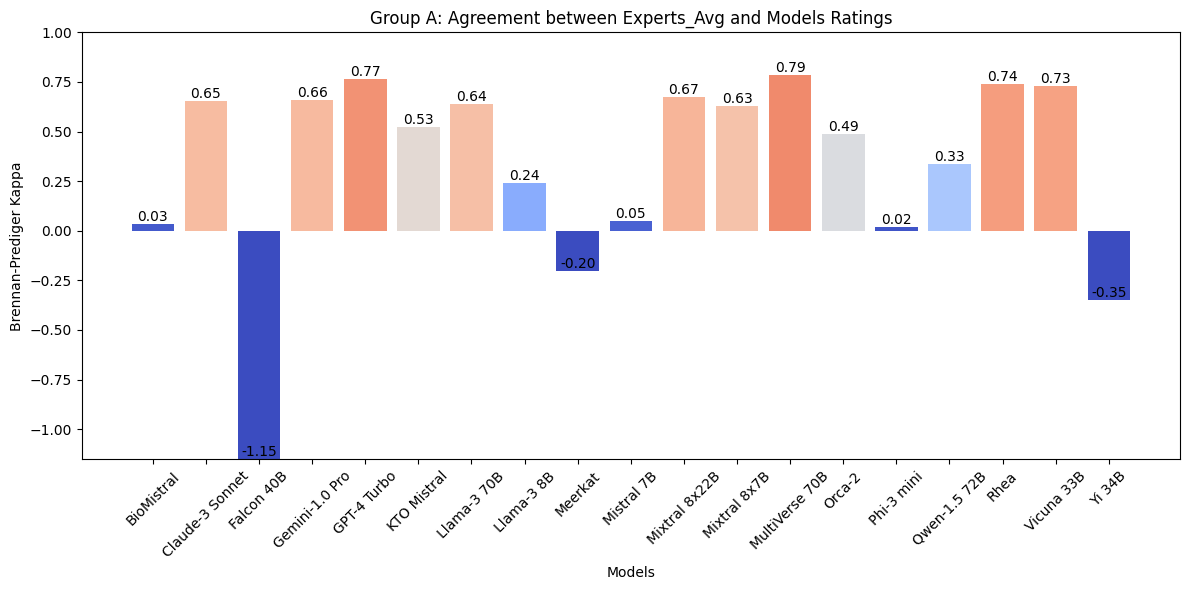

In [13]:
rater1_columns = ['Experts_Avg' for _ in range(len(model_names))]

stat_groupA_df = plot_agreement_barplot(groupA_df, rater1_columns, model_names, 
                                        'Experts_Avg', 'Models',
                                        categories, agreement_coef, 
                                        topic_name=topic_name,
                                        xlabel='Models', figsize=(12,6))

stat_groupA_df = stat_groupA_df.T.rename_axis('Model', axis=1)
stat_groupA_df.round(2)

Models Inter-Rater Agreement

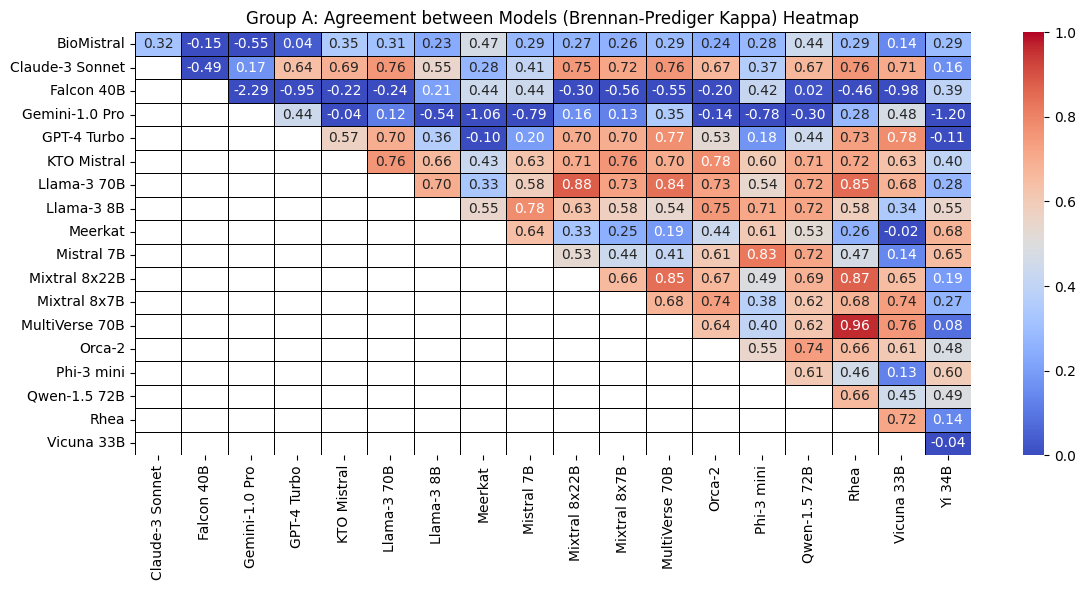

In [14]:
models_agreementA_df = plot_models_agreement_heatmap(groupA_df, model_names, 
                                                     categories, agreement_coef, 
                                                     topic_name='Group A', figsize=(12,6))

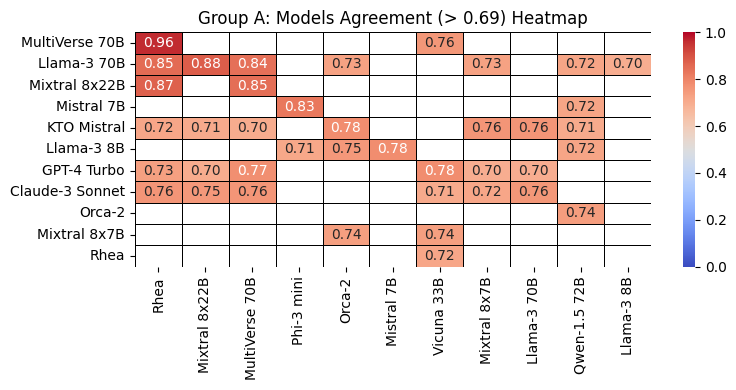

In [15]:
model_agreements_gt_per(models_agreementA_df, 0.69, topic_name, figsize=(8, 4))

### Group B Analysis
Group B: Total scores out of 75.

In [16]:
topic_name = 'Group B'
categories = list(range(15,76))
agreement_coef = "Brennan-Prediger Kappa"

In [17]:
if 'Expert1' in groupB_df.columns and 'Expert2' in groupB_df.columns:
    agreement_expert1_vs_expert2 = calculate_statistics(groupB_df, 'Expert1', 'Expert2', categories)
    print(f"Agreement between Expert 1 and Expert 2:")
    print(pd.DataFrame.from_dict(agreement_expert1_vs_expert2, orient='index', columns=['Value']))

Agreement between Expert 1 and Expert 2:
                           Value
Brennan-Prediger Kappa  0.960370
Weighted Kappa          0.883196
Spearman's Rho          0.926593
Kendall's Tau           0.802223
ICC3                    0.883613
Gwet's AC2              0.963800


#### Descriptive Statistics

In [18]:
if 'Expert1' in groupB_df.columns and 'Expert2' in groupB_df.columns:
    groupB_df.drop(columns=['Expert1', 'Expert2'], inplace=True)
statB_df = groupB_df.describe().round(2).T
columns_to_convert_type = ['count', 'min', 'max']
statB_df[columns_to_convert_type] = statB_df[columns_to_convert_type].astype(int)
statB_df.rename_axis('Model', axis=1, inplace=True)
statB_df

Model,count,mean,std,min,25%,50%,75%,max
Experts_Avg,194,31.58,10.96,11,24.50,30.0,39.00,72
BioMistral,194,52.65,11.17,19,45.00,52.0,59.75,75
Claude-3 Sonnet,194,49.13,9.73,20,44.00,49.0,55.00,72
Falcon 40B,194,59.86,8.72,15,60.00,60.0,60.00,75
Gemini-1.0 Pro,194,37.02,8.45,16,32.00,38.0,44.00,63
GPT-4 Turbo,194,44.31,8.20,20,39.00,44.5,50.00,63
KTO Mistral,194,52.05,14.80,15,43.00,54.5,62.00,75
Llama-3 70B,194,45.98,7.66,25,42.00,47.0,51.00,62
Llama-3 8B,194,48.30,9.26,21,42.25,50.0,56.00,64
Meerkat,194,66.26,11.12,19,63.25,71.0,75.00,75


Box Plot

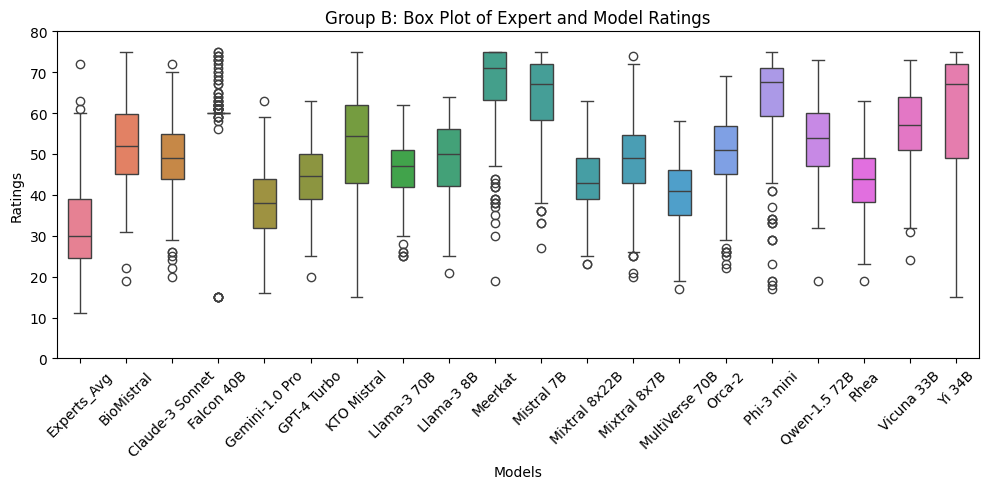

In [19]:
create_plot('boxplot', data=groupB_df,
            figsize=(10, 5), ylim=(0, 80),
            xlabel="Models", ylabel="Ratings",
            title=f'{topic_name}: Box Plot of Expert and Model Ratings',
            xticks_rotation=45)

Expert-Models Inter-Rater Agreement

Model,Brennan-Prediger Kappa,Weighted Kappa,Spearman's Rho,Kendall's Tau,ICC3,Gwet's AC2
BioMistral,0.05,0.03,0.11,0.08,0.12,0.08
Claude-3 Sonnet,0.35,0.14,0.39,0.28,0.41,0.38
Falcon 40B,-0.55,-0.01,-0.03,-0.02,-0.06,0.19
Gemini-1.0 Pro,0.79,0.36,0.44,0.31,0.45,0.81
GPT-4 Turbo,0.59,0.23,0.42,0.30,0.43,0.61
KTO Mistral,0.06,0.17,0.42,0.29,0.42,0.07
Llama-3 70B,0.51,0.18,0.43,0.30,0.42,0.54
Llama-3 8B,0.38,0.19,0.44,0.32,0.45,0.41
Meerkat,-1.09,0.04,0.20,0.14,0.23,-0.77
Mistral 7B,-0.82,0.07,0.41,0.29,0.44,-0.74


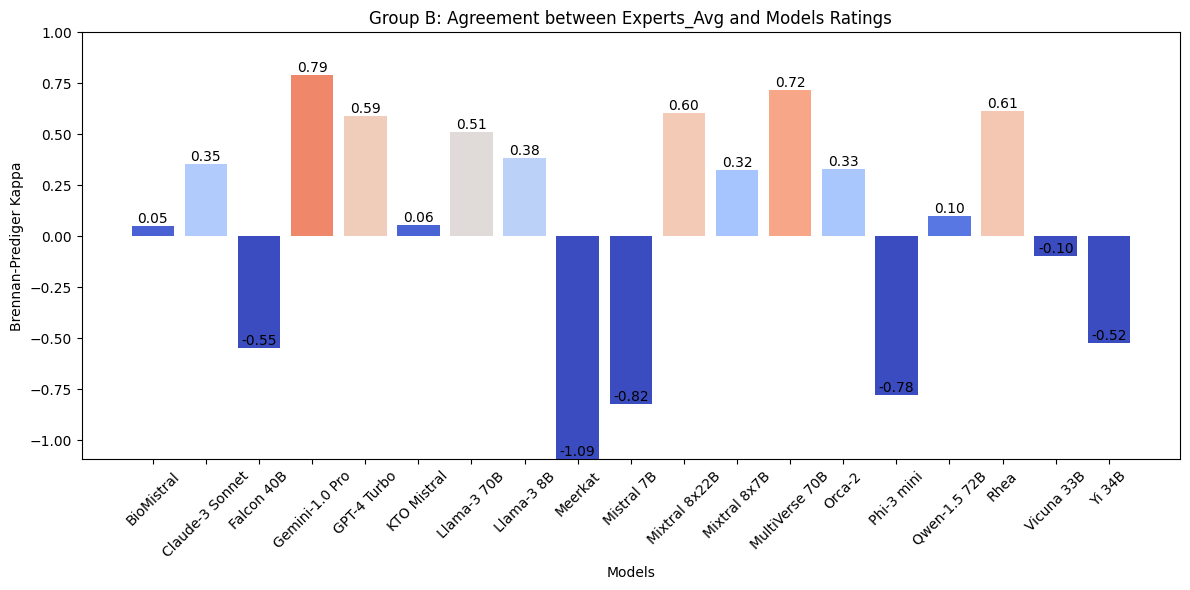

In [20]:
rater1_columns = ['Experts_Avg' for _ in range(len(model_names))]

stat_groupB_df = plot_agreement_barplot(groupB_df, rater1_columns, model_names, 
                                        'Experts_Avg', 'Models',
                                        categories, agreement_coef, 
                                        topic_name=topic_name,
                                        xlabel='Models', figsize=(12,6))

stat_groupB_df = stat_groupB_df.T.rename_axis('Model', axis=1)
stat_groupB_df.round(2)

Models Inter-Rater Agreement

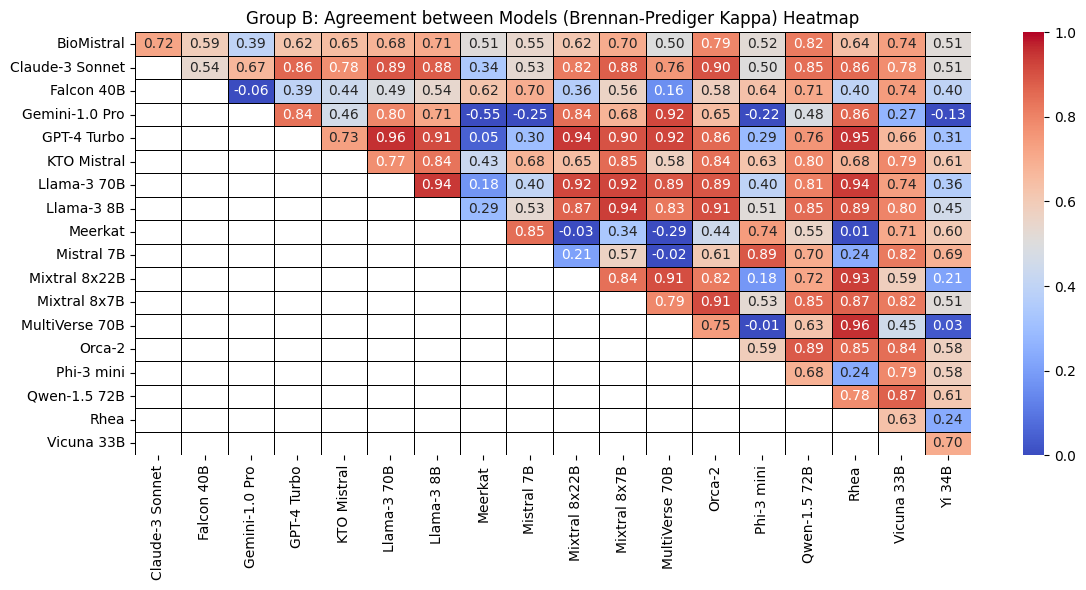

In [21]:
models_agreementB_df = plot_models_agreement_heatmap(groupB_df, model_names, 
                                                     categories, agreement_coef, 
                                                     topic_name, figsize=(12,6))

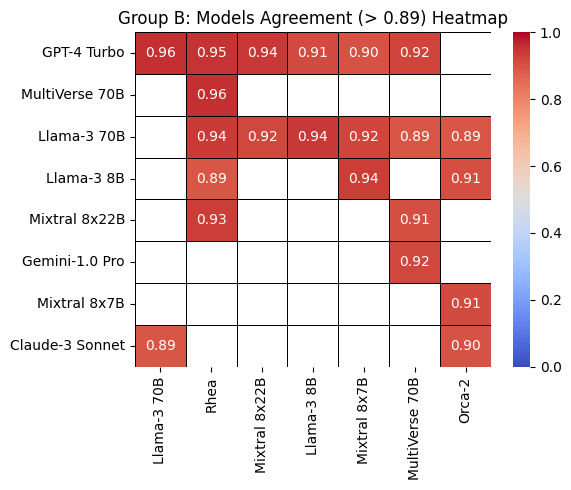

In [22]:
model_agreements_gt_per(models_agreementB_df, 0.89, topic_name, figsize=(6, 5))

### Group C Analysis
Group C: individual 15 scores

In [23]:
topic_name = "Group C"
categories = list(range(1,6))
agreement_coef = "Brennan-Prediger Kappa"

c:\Users\ku500989\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ku500989\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ku500989\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ku500989\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal ap

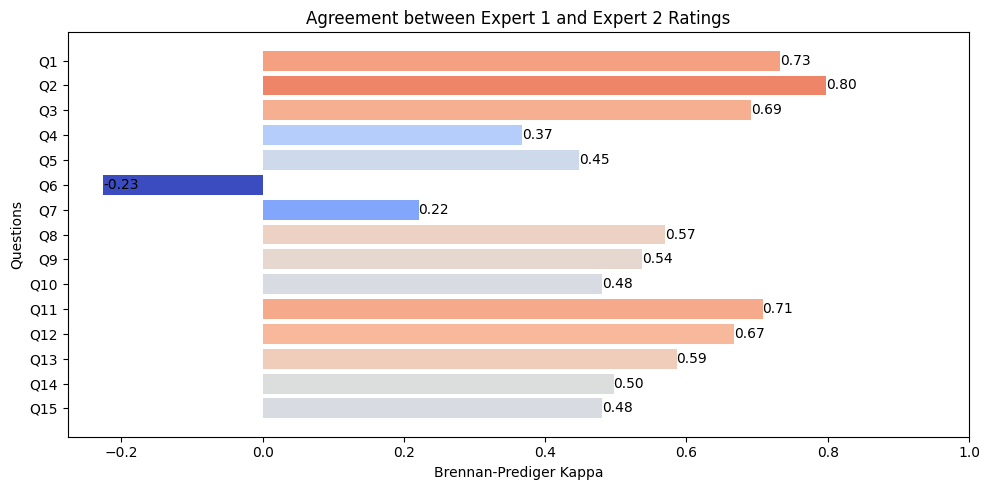

In [24]:
if 'Expert1' in groupC_df.columns and 'Expert2' in groupC_df.columns:
    plot_agreement_barplot(groupC_df, EXPERT1_COLUMNS, EXPERT2_COLUMNS,
                           'Expert 1', 'Expert 2',
                           categories, agreement_coef, orientation='horizontal',
                           ylabel='Questions', ticklabels=MODEL_15_SCORE_COLUMNS,
                           figsize=(10,5))

Expert-Model Inter-Rater Agreement

In [25]:
stat_groupC_df = pd.DataFrame(index=MODEL_15_SCORE_COLUMNS, columns=model_names, dtype=float)

for model_name in model_names:
    for question_num in range(1, 16):
        expert_col = f"Experts_Avg Q{question_num}"
        model_col = f"{model_name} Q{question_num}"
        statistics = calculate_statistics(groupC_df, expert_col, model_col, categories)
        stat_groupC_df.at[f"Q{question_num}", model_name] = round(statistics.get(agreement_coef), 2)

# stat_groupC_df['Question Average'] = question_avg
# stat_groupC_df.loc['Model Average'] = model_avg

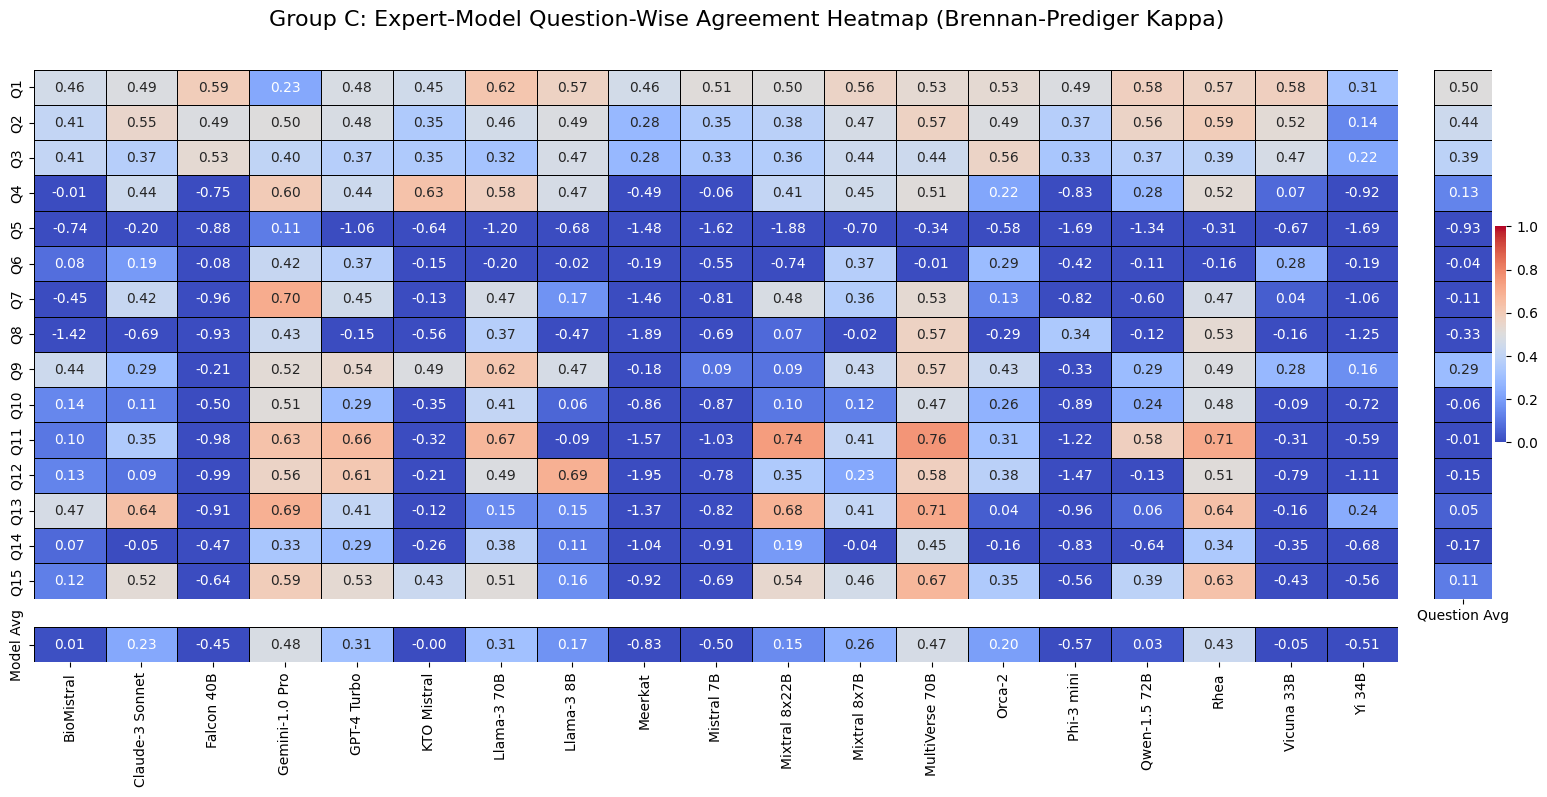

In [26]:
plot_questionwise_agreement_heatmap(stat_groupC_df, agreement_coef, topic_name)#, figsize=(14,6))

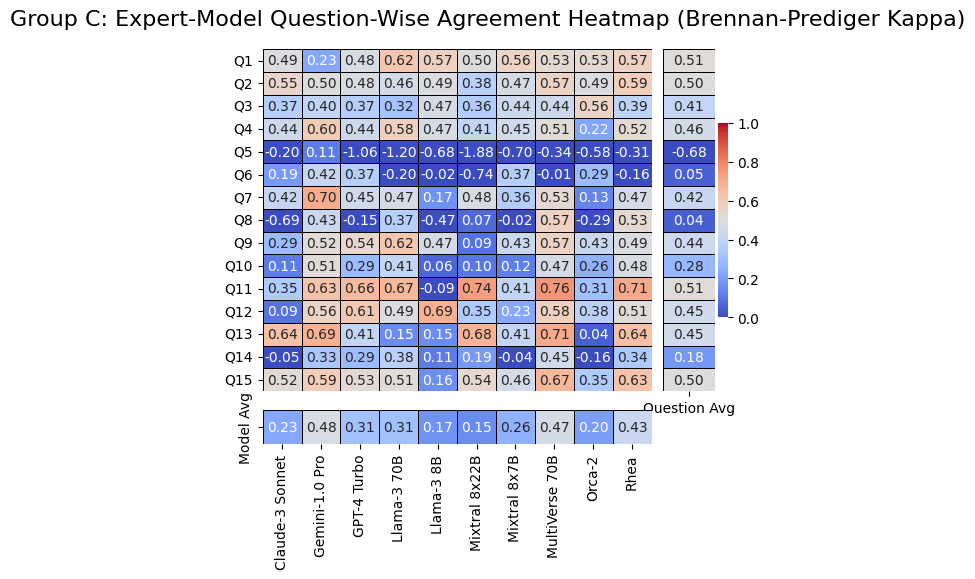

In [27]:
stat_groupC_filtered_df = stat_groupC_df.drop(
    columns=['BioMistral', 'Falcon 40B', 'KTO Mistral', 'Meerkat', 'Mistral 7B', 
             'Phi-3 mini', 'Qwen-1.5 72B', 'Vicuna 33B', 'Yi 34B', ],
)

plot_questionwise_agreement_heatmap(stat_groupC_filtered_df, agreement_coef, topic_name, figsize=(10,6))